In [2]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf, rlocus, step, feedback, lsim, bode, ss
from control import pade

from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found


#
# B747 longitudinal dynamics
# AA271a
# B747 at Mach 0.8, 40,000ft, level-flight
# From Etkin and Reid page 166
#


In [3]:
INT=tf(1,[1, 0]);
# metric   
Xu=-1.982e3;Xw=4.025e3;
Zu=-2.595e4;Zw=-9.030e4;Zq=-4.524e5;Zwd=1.909e3;
Mu=1.593e4;Mw=-1.563e5;Mq=-1.521e7;Mwd=-1.702e4;

g=9.81;theta0=0;S=511;cbar=8.324;
U0=235.9;Iyy=.449e8;m=2.83176e6/g;cbar=8.324;rho=0.3045;
Xdp=.3*m*g;Zdp=0;Mdp=0;
Xde=-3.818e-6*(1/2*rho*U0**2*S);Zde=-0.3648*(1/2*rho*U0**2*S);
Mde=-1.444*(1/2*rho*U0**2*S*cbar);

# add theta state [w p th]
Asp = np.array([[Zw/m,U0, 0],[(Mw+Mwd*Zw/m)/Iyy, (Mq+Mwd*U0)/Iyy, 0],[0, 1, 0]])
Bsp = np.array([Zde/m , (Mde + Mwd*Zde/m)/Iyy, 0]).reshape(3,1)

Gth=near_zero(tf(ss(Asp,Bsp,np.array([0, 0, 1]),0)))
print(Gth)
Gw=near_zero(tf(ss(Asp,Bsp,np.array([1, 0, 0]),0)))
print(Gw)
Gh = INT*near_zero(tf(ss(Asp,Bsp,np.array([-1, 0, U0]),0)))
print(Gh)


<TransferFunction>: sys[3]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    -1.157 s - 0.3435
--------------------------
s^3 + 0.741 s^2 + 0.9272 s

<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   -5.471 s^2 - 275.3 s
--------------------------
s^3 + 0.741 s^2 + 0.9272 s

<TransferFunction>: sys[10]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


5.471 s^2 + 2.343 s - 81.04
----------------------------
s^4 + 0.741 s^3 + 0.9272 s^2



TransferFunction(array([   5.471,    2.343,  -81.036]), array([   1.000,    0.741,    0.927,    0.000,    0.000]))

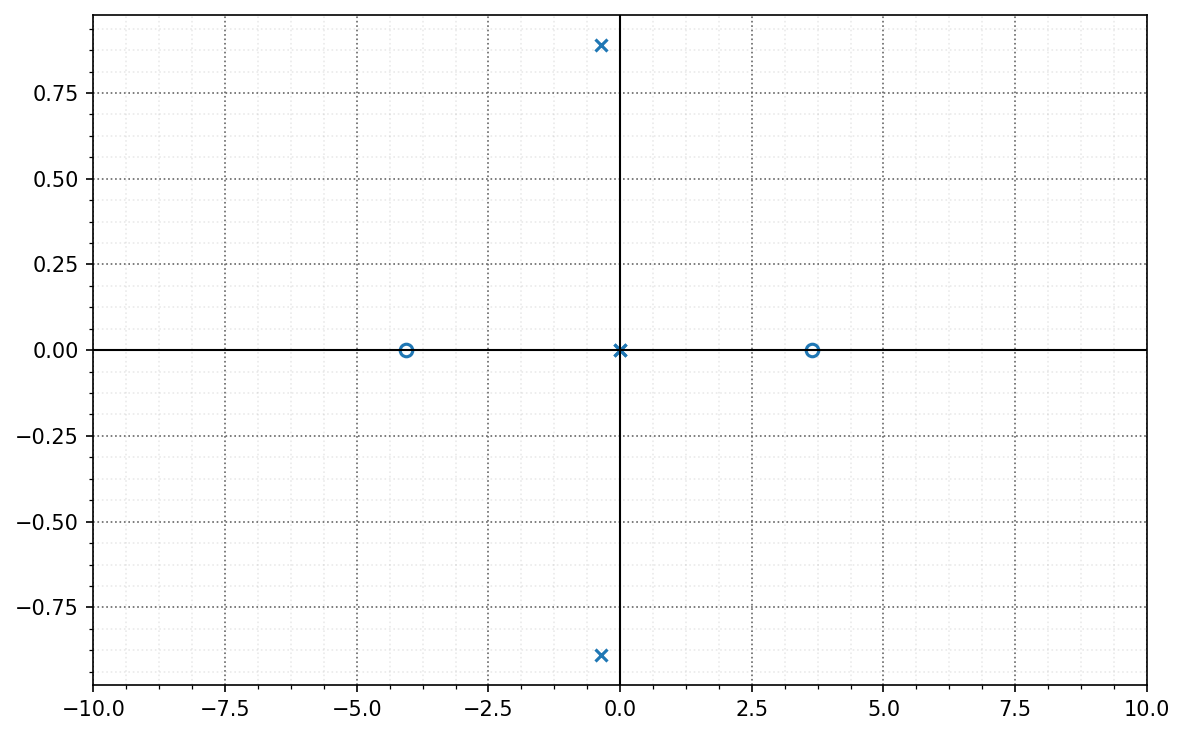

In [4]:
Ghde = near_zero(Gh)
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150)
control.pzmap(Ghde,ax=ax)
ax.set_xlim(-10,10)
nicegrid(ax)
Ghde

[-0.26209066+0.j         -1.97485707+1.99100047j -1.97485707-1.99100047j]

Found breakin/out at K = 2.173
At possible locations s = -4.001


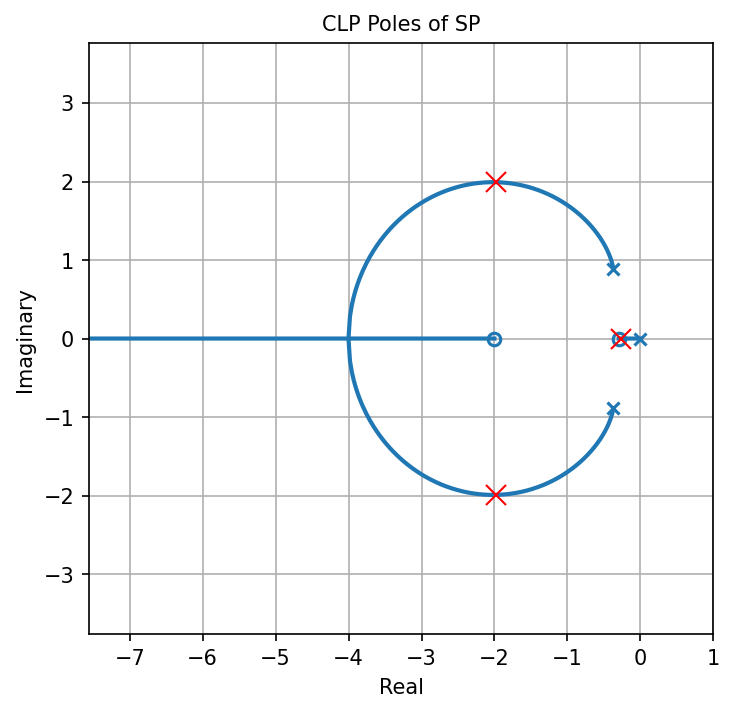


Found breakin/out at K = 0.000
At possible locations s = 0.000

Found breakin/out at K = 1.099
At possible locations s = -5.514

Found breakin/out at K = 0.000
At possible locations s = -0.127

Found breakin/out at K = 3.235
At possible locations s = 5.704


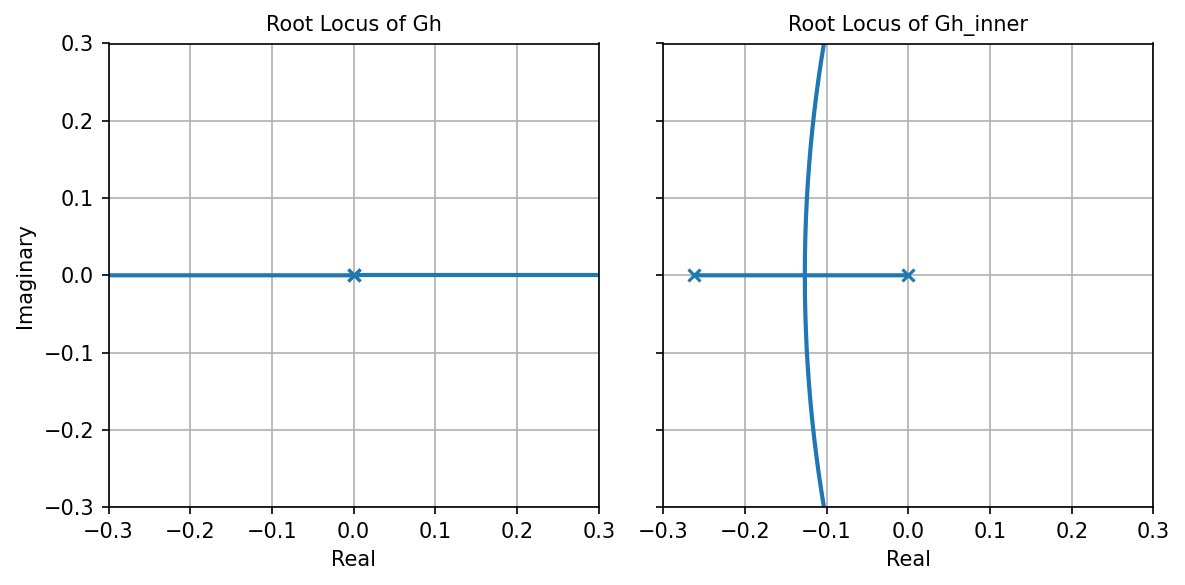

<TransferFunction>: sys[150]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         6.942 s + 2.061
---------------------------------
s^3 + 4.212 s^2 + 8.899 s + 2.061

<TransferFunction>: sys[154]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    -32.83 s^2 - 14.06 s + 486.2
-------------------------------------
s^4 + 4.212 s^3 + 8.899 s^2 + 2.061 s

<TransferFunction>: sys[10]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


5.471 s^2 + 2.343 s - 81.04
----------------------------
s^4 + 0.741 s^3 + 0.9272 s^2



array([  -4.069,    3.640])

In [17]:
# Inner loop gains
Kp=-6;Kd = .5*Kp # old design
Acl = Asp - Bsp*np.array([0, Kd, Kp])
ev_inner = np.linalg.eig(Acl)
print(ev_inner[0])

# Inner loop controller
Gc_th = tf([Kd, Kp],[1])
L = Gth*Gc_th

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,sharex=True)
rlocus(L,Root_Locus_gains(L),grid=False,ax=ax)
Gcl = feedback(L,1)
plt.plot(Gcl.poles().real, Gcl.poles().imag, 'rx', markersize=10)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('CLP Poles of SP')
plt.suptitle("")
plt.grid(True)
plt.show()

Gth_inner = near_zero(tf(ss(Acl,Bsp*Kp,np.array([0, 0, 1]),0)))
Gh_inner = INT*near_zero(tf(ss(Acl,Bsp*Kp,np.array([-1, 0, U0]),0)))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharex=True, sharey=True)

# Plot root locus of Gh
rlocus(Ghde, Root_Locus_gains(Ghde), ax=ax[0], grid=False)
ax[0].set_title('Root Locus of Gh')
ax[0].set_xlabel('Real')
ax[0].set_ylabel('Imaginary')
ax[0].set_xlim([-.3, .3])
ax[0].set_ylim([-.3, .3])

# Plot root locus of Gh_inner
rlocus(Gh_inner, Root_Locus_gains(Gh_inner,logspace(-4,-2,1000)), ax=ax[1], grid=False)
ax[1].set_title('Root Locus of Gh_inner')
ax[1].set_xlabel('Real')
ax[1].set_xlim([-.3, .3])
ax[1].set_ylim([-.3, .3])

plt.tight_layout()
plt.show()

print(Gth_inner)
print(Gh_inner)
print(Gh)

np.roots(Gh_inner.num[0][0])

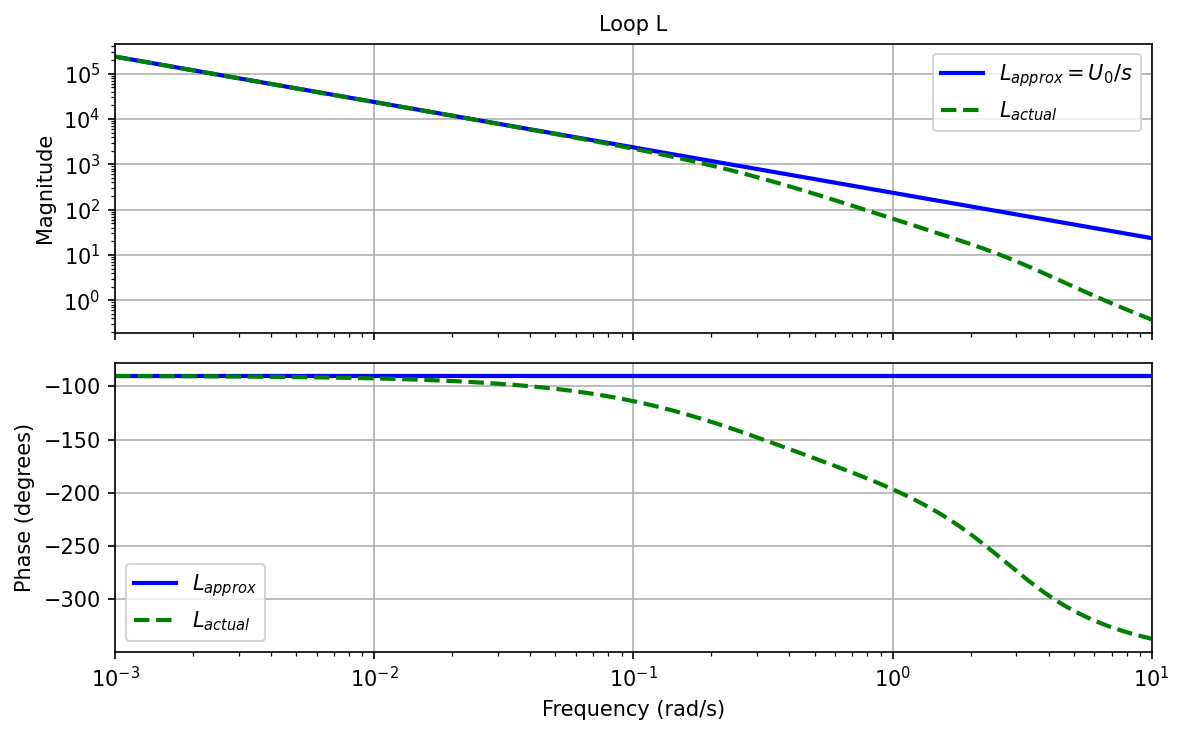

In [7]:
omega = np.logspace(-3,1,1000)
j = complex(0,1)
G1f = U0*INT(j*omega)
G2f = Gh_inner(j*omega)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,sharex=True)
ax[0].loglog(omega,np.abs(G1f),'b',label=r'$L_{approx} = U_0/s$')
ax[1].semilogx(omega,np.angle(G1f)*r2d,'b',label=r'$L_{approx}$')
ax[0].loglog(omega,np.abs(G2f),'g--',label=r'$L_{actual}$')
ax[1].semilogx(omega,np.unwrap(np.angle(G2f))*r2d,'g--',label=r'$L_{actual}$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (rad/s)')
ax[0].set_title('Loop L')
savefig("figs/gh_inner.pdf", dpi=600)
plt.show()

[  -0.028]
[-1.98129694+1.98759609j -1.98129694-1.98759609j -0.10027763+0.05822884j
 -0.10027763-0.05822884j -0.04865567+0.j        ]

Found breakin/out at K = 1.235
At possible locations s = -0.056

Found breakin/out at K = -0.000
At possible locations s = 0.000


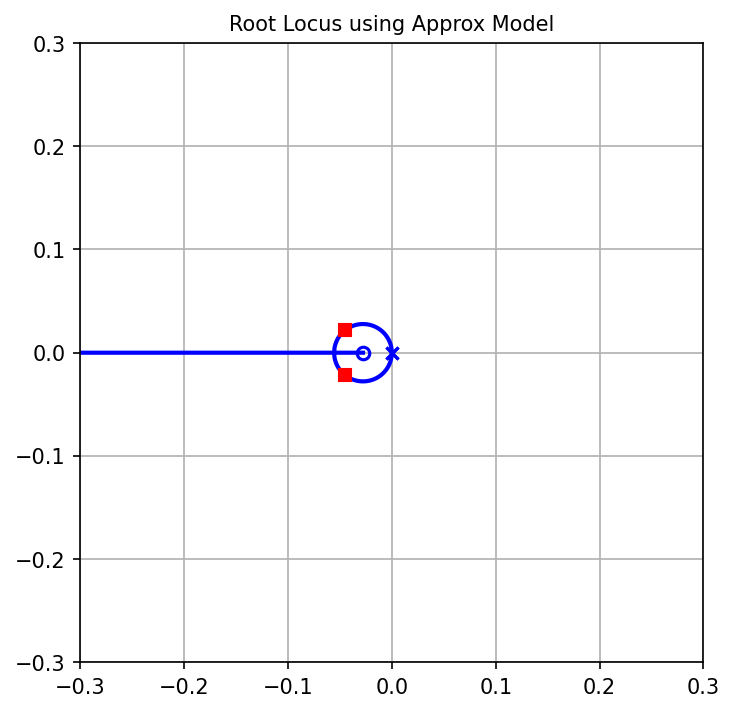


Found breakin/out at K = -0.000
At possible locations s = 0.000


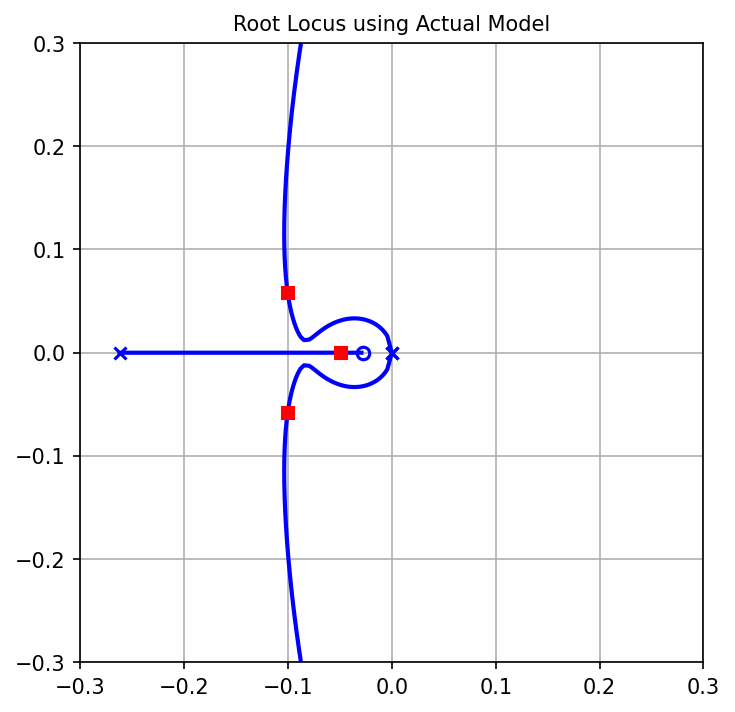

In [25]:
wn = .05;  # desired natural frequency
z = .9;  #[1 2*z*wn wn**2] = [1 kp*U0 Ki*U0]
K2 = 2*z*wn/U0
Ki = wn**2/U0
PI = tf([K2, Ki],[1, 0]) # PI controller
print(np.roots(PI.num[0][0]))
L = Gh_inner*PI; # actual loop
Hcl = feedback(L,1); # negative fb
ev_h = Hcl.poles()
print(ev_h)

L_approx = PI*U0*INT;
Hcl_approx = ss(feedback(L_approx,1)); # negative fb
ev_h_approx = np.linalg.eig(Hcl_approx.A)

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,sharex=True)
rlocus(L_approx,kvect=Root_Locus_gains(L_approx),color='b',grid = False)
temp_cl = feedback(L_approx,1)
plt.plot(temp_cl.poles().real,temp_cl.poles().imag,'rs')
ax.set_xlim([-.3, .3])
ax.set_ylim([-.3, .3])
ax.set_title('Root Locus using Approx Model')
plt.suptitle("")
savefig("figs/RL_approx.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,sharex=True)
rlocus(L,kvect=Root_Locus_gains(L,Krange=np.logspace(-1,.75,3000)),color='b',grid=False);
temp_cl = feedback(L,1)
plt.plot(temp_cl.poles().real,temp_cl.poles().imag,'rs')
ax.set_xlim([-.3, .3])
ax.set_ylim([-.3, .3])
ax.set_title('Root Locus using Actual Model')
plt.suptitle("")
savefig("figs/RL_act.pdf", dpi=600)
plt.show()


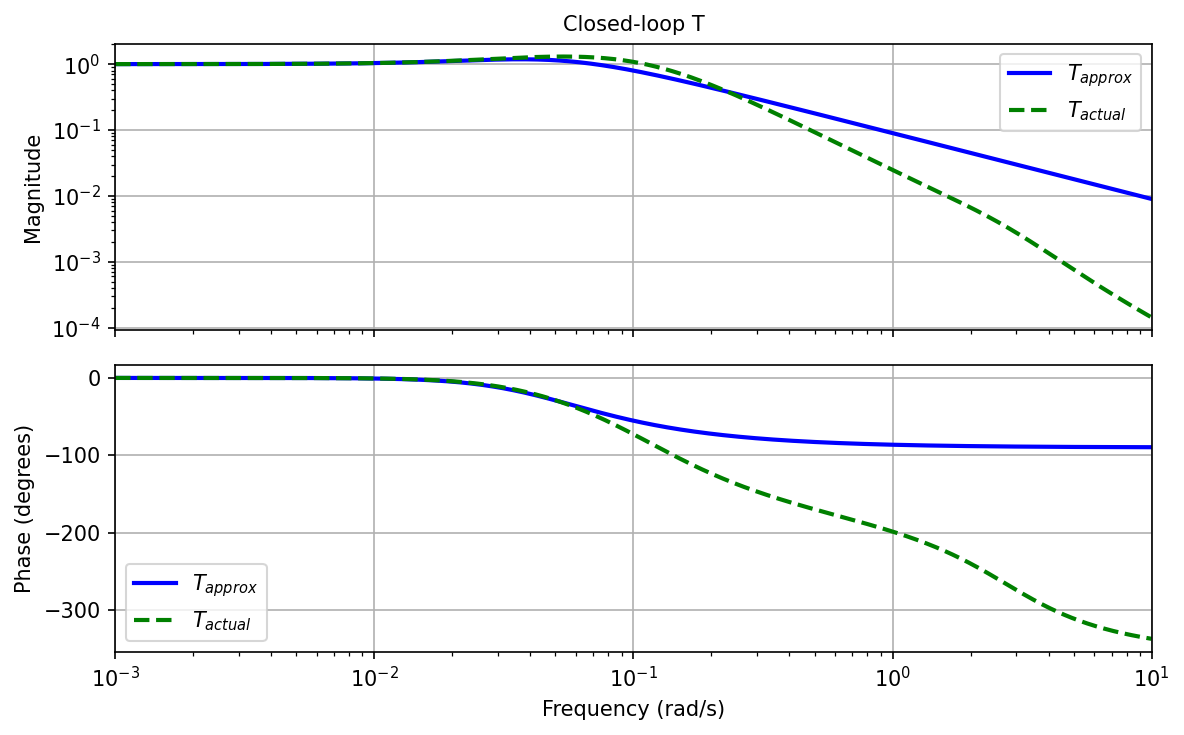

In [9]:
G1f = Hcl_approx(j*omega)
G2f = Hcl(j*omega)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,sharex=True)
ax[0].loglog(omega,np.abs(G1f),'b',label=r'$T_{approx}$')
ax[1].semilogx(omega,np.angle(G1f)*r2d,'b',label=r'$T_{approx}$')
ax[0].loglog(omega,np.abs(G2f),'g--',label=r'$T_{actual}$')
ax[1].semilogx(omega,np.unwrap(np.angle(G2f))*r2d,'g--',label=r'$T_{actual}$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (rad/s)')
ax[0].set_title('Closed-loop T')
savefig("figs/ghcl.pdf", dpi=600)
plt.show()

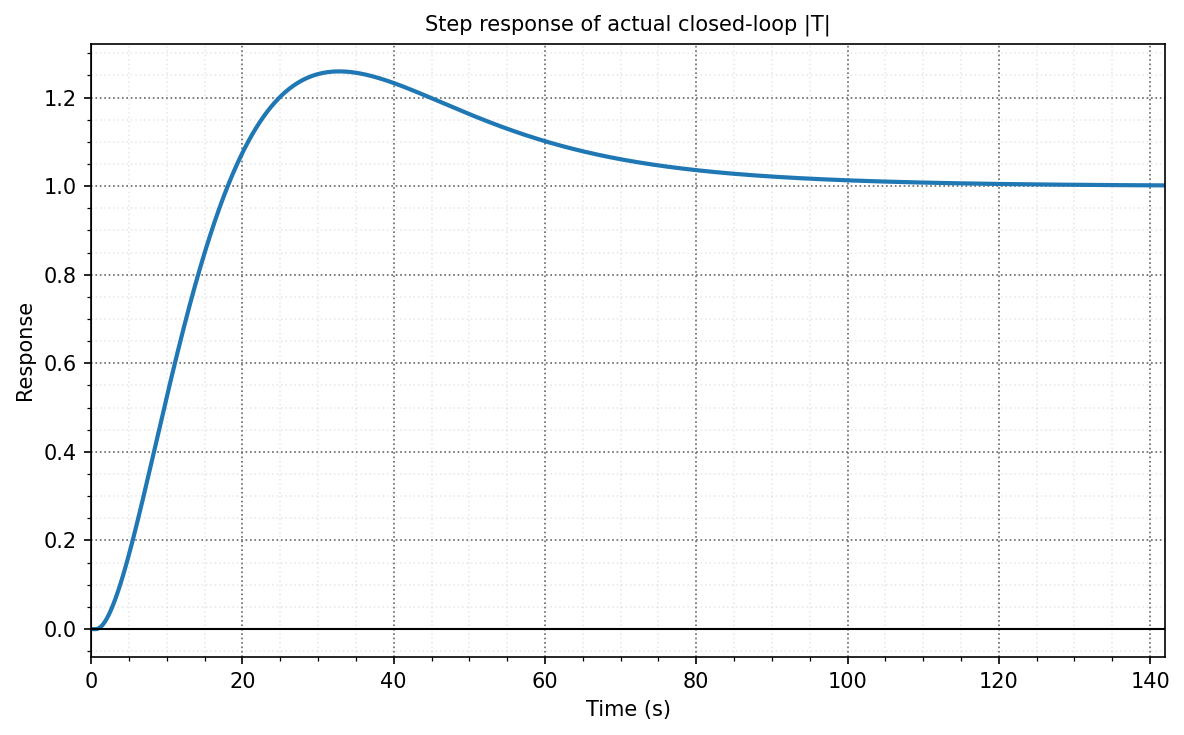

In [10]:
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex=True)
y,t = step(Hcl)
plt.plot(t,y)
nicegrid(ax)
plt.title('Step response of actual closed-loop |T|')
plt.xlabel('Time (s)')
plt.ylabel('Response')
savefig("figs/hcl.pdf", dpi=600)
plt.show()